# Map fires in KI using Entropy/Alpha
- Fire Mapping in SAR Reference https://www.mdpi.com/2072-4292/9/8/764/htm
- Locate Datasets over KI using [Copernicus Hub Australia](https://copernicus.nci.org.au/sara.client/#/explore?page=1&collection=S1&instrument=C-SAR&productType=SLC&startDate=2019-12-01&completionDate=2020-01-31&geometry=POLYGON((15260443.201246085%20-4267941.237780532,15305388.173877768%20-4264578.008535984,15309974.395574879%20-4296375.812302617,15262277.68992493%20-4295152.819850055,15260443.201246085%20-4267941.237780532))).
- Download them form [NCI Thredds](http://dapds00.nci.org.au/thredds/catalog/fj7/Copernicus/Sentinel-1/C-SAR/SLC/catalog.xml).
- Load them via GDAL [Complex Tiff](https://gdal.org/drivers/raster/gtiff.html) with Cfloat64 datatype, allocate enough RAM for this.
- Analyse them in Slant Range with [PyRAT](https://github.com/birgander2/PyRAT)
- Convert to Ground range/Orthorectified versions using SNAP/Gamma

In [1]:
import requests
import zipfile
import os
import re
import urllib.request
import glob
import xarray
import zipfile
from pylab import plot, show, imshow, figure
import matplotlib.pyplot as plt
import pyodata
from auscophub import saraclient
from shapely.geometry import Point

## Locate Images via Copernicus Hub SARA API
- Use location of [Kangaroo Island](https://tools.wmflabs.org/geohack/geohack.php?pagename=Kangaroo_Island&params=35_50_S_137_15_E_type:isle_region:AU-SA_scale:1000000)
- Use Copernicus Hub [SARA search API](https://github.com/CopernicusAustralasia/auscophub/blob/master/bin/auscophub_searchSara.py)

In [2]:
ki_polygon = Point(137.25,-35.833333).buffer(0.1)

In [3]:
queryParams = [
               'collection=S1',
               'instrument=C-SAR',
               'productType=SLC',
               'startDate=2019-12-01',
               'completionDate=2020-01-31',
               'page=1',
              'geometry='+ki_polygon.to_wkt()]

In [4]:
urlOpener = saraclient.makeUrlOpener()
results = saraclient.searchSara(urlOpener, 1, queryParams)

In [5]:
def str_lat(lat):
    if lat < 0:
        return f'{abs(lat)}S'
    return f'{lat}N'
    
def str_lon(lon): 
    if lon < 0:
        return f'{abs(lon)}W'
    return f'{lon}E'
    
def infer_nci_folder(scene_props):
    ql_url = scene_props['quicklook']
    path_part = ql_url.rsplit('/',2)[1]
    x,y = scene_props['centroid']['coordinates']
    # Round x,y to 5
    round_x = 5 * round(x/5)
    round_y = 5 * round(y/5)
    plus_round_x = round_x + 5
    plus_round_y = round_y - 5
    composed_path_part = f'{str_lat(round_y)}{str_lon(round_x)}-{str_lat(plus_round_y)}{str_lon(plus_round_x)}'
    if path_part != composed_path_part:
        raise Exception
    return path_part

In [6]:
thumbnails = [x['properties']['thumbnail'] for x in results]

In [7]:
scene_ids = [x['properties']['productIdentifier'] for x in results]

In [8]:
base_url = 'http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC'

In [9]:
loc_folder = infer_nci_folder(results[0]['properties'])

In [10]:
def parse_ym(granule_name):
    ym = granule_name.replace('S1A_IW_SLC__1SDV_','')[:6]
    return ym[:4],ym[-2:]

In [11]:
def compose_url(scene_id):
    year,month = parse_ym(scene_id)
    full_url = f'{base_url}/{year}/{year}-{month}/{loc_folder}/{scene_id}.zip'
    return full_url

In [12]:
for scene in scene_ids:
    url = compose_url(scene)
    print(url)
    filename = f'{scene}.zip'
    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url,filename)
        except HTTPError as hte:
            print(f"Failed to Download:{url}")

http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2020/2020-01/35S135E-40S140E/S1A_IW_SLC__1SDV_20200123T200533_20200123T200602_030932_038D12_A9BA.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2020/2020-01/35S135E-40S140E/S1A_IW_SLC__1SDV_20200111T200534_20200111T200603_030757_0386EE_B6A2.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S135E-40S140E/S1A_IW_SLC__1SDV_20191230T200534_20191230T200603_030582_0380DF_1797.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S135E-40S140E/S1A_IW_SLC__1SDV_20191218T200535_20191218T200604_030407_037ADB_ECEF.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S135E-40S140E/S1A_IW_SLC__1SDV_20191206T200535_20191206T200604_030232_0374CC_4087.zip


In [13]:
for scene in scene_ids:
    filename = f'{scene}.zip'
    out_dir = f'{scene}.SAFE'
    print(out_dir)
    if not os.path.isdir(f'{scene}.SAFE'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            try:
                zip_ref.extractall('.')
            except:
                print(f"Corrupted :{filename}")
                os.unlink(filename)

S1A_IW_SLC__1SDV_20200123T200533_20200123T200602_030932_038D12_A9BA.SAFE
S1A_IW_SLC__1SDV_20200111T200534_20200111T200603_030757_0386EE_B6A2.SAFE
S1A_IW_SLC__1SDV_20191230T200534_20191230T200603_030582_0380DF_1797.SAFE
S1A_IW_SLC__1SDV_20191218T200535_20191218T200604_030407_037ADB_ECEF.SAFE
S1A_IW_SLC__1SDV_20191206T200535_20191206T200604_030232_0374CC_4087.SAFE


In [14]:
import os
import numpy as np

import osgeo.gdal as gdal

datasets = glob.glob('S1A*.SAFE/measurement')
data_collection = {}
for data in datasets:
    tiff_files = glob.glob(os.path.join(data,'*.tiff'))
    for tiff in tiff_files:
        if 's1a-iw2' in tiff:
            ds = gdal.Open(tiff)
            xsize = ds.RasterXSize
            ysize = ds.RasterYSize
            data = ds.ReadAsArray(int(xsize/2),int(ysize/2),1000,1000)
            data_collection[tiff] = data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


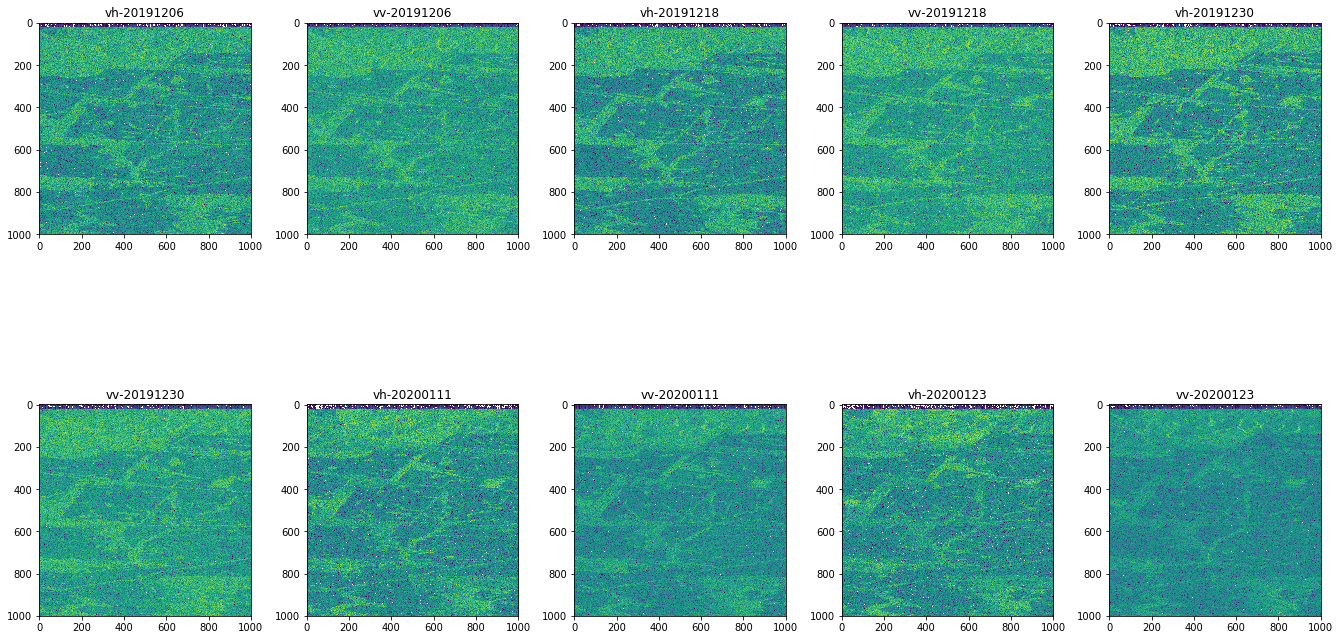

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=5, constrained_layout=True)
fig.set_size_inches(18.5, 10.5, forward=True)
i = 0
keys = list(data_collection.keys())
for ax in axs.flat:
    key = keys[i]
    decibel = np.log(np.absolute(data_collection[keys[i]])**2)*10
    ax.imshow(decibel)
    basename = os.path.basename(key)
    ax.set_title(basename[12:23])
    i += 1

## Install PyRAT before next steps
- Pip install PyQT5
- Pip install Cython for acceleration
- Pip install PyRAT or clone from github to use from source

In [16]:
!python3 -m pip install --user PyQT5 Cython git+https://github.com/birgander2/PyRAT

  Cloning https://github.com/birgander2/PyRAT to /tmp/pip-req-build-_l1wn0pb
  Running command git clone -q https://github.com/birgander2/PyRAT /tmp/pip-req-build-_l1wn0pb
ERROR: Files/directories not found in /tmp/pip-req-build-_l1wn0pb/pip-egg-info
